# Descriptive Analysis

Loading necessary libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import logging
logging.basicConfig(
    level= logging.INFO,
    format= "%(asctime)s - %(levelname)s - %(message)s"
)

Loading the clean data from parquet files

In [2]:
anki: pd.DataFrame = pd.read_parquet("../data/clean_anki.parquet")
flowmodoro: pd.DataFrame = pd.read_parquet("../data/clean_flowmodoro.parquet")
bir: pd.DataFrame = pd.read_parquet("../data/clean_bir.parquet")
logging.info("Loadded parquet files into dataframes")

2025-11-18 17:27:36,174 - INFO - Loadded parquet files into dataframes


## Parameters

### Total time

In [3]:
total_mins_bir: float = bir.sum().sum()
total_hours_bir: float = round(total_mins_bir / 60, 2)
print(f"Total time spent studying for bir = {total_hours_bir}")

Total time spent studying for bir = 774.4


### Time spent by activity

In [4]:
total_by_act: pd.DataFrame = round(bir.sum() / 60, 1).reset_index()
total_by_act["activity"] = total_by_act["activity"].map({
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs"
})
total_by_act = total_by_act.rename(columns={0: "time"})

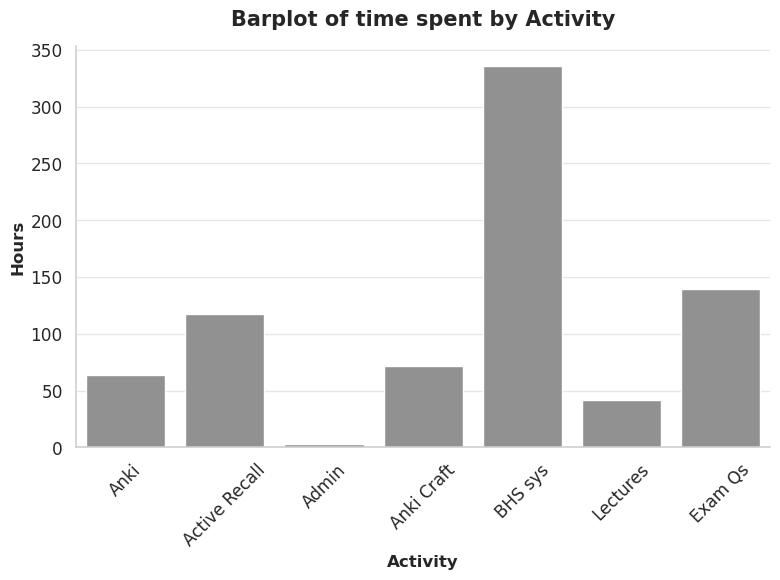

In [5]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=total_by_act,
    x="activity",
    y="time",
    color="#919191F1", 
    edgecolor=None
)

ax.set_xlabel("Activity", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Barplot of time spent by Activity", fontsize=15, weight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/barplot_time_activity.png", dpi=300, bbox_inches="tight")
plt.show()

### Cumulative time per week and activity

Lets create a dataframe grouped by week 

In [22]:
bir_by_date: pd.DataFrame = bir.reset_index().copy()
bir_by_date["date_day"] = pd.to_datetime(bir_by_date["date_day"])
bir_by_date["total_mins"] = bir_by_date.drop(columns="date_day").sum(axis=1)
bir_by_date["total_hours"] = bir_by_date["total_mins"] / 60
bir_gr_week = bir_by_date.copy()
bir_gr_week["week"] = bir_gr_week["date_day"].dt.to_period("W")
bir_gr_week = bir_gr_week.drop(columns=["date_day"])
bir_gr_week = bir_gr_week.groupby("week").sum()
bir_gr_week = bir_gr_week.rename(columns= {
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs",
    "total_mins": "Total Minmutes"
})
bir_gr_week = bir_gr_week.drop(columns=["total_hours"])

In [25]:
activity_cols: list = [c for c in bir_gr_week.columns if c not in {"week"}]
bir_gr_week_cumsum: pd.DataFrame = bir_gr_week.copy()
bir_gr_week_cumsum[activity_cols] = bir_gr_week_cumsum[activity_cols].cumsum().div(60)

In [26]:
plot_cols: list = [c for c in bir_gr_week_cumsum.columns if c not in {"week"}]

df_long = bir_gr_week_cumsum.reset_index() \
                              .melt(id_vars='week',
                                    value_vars=plot_cols,
                                    var_name='activity',
                                    value_name='hours')

# sns.set_theme(
#     style="white",
#     font_scale=1.1,
#     rc={
#         "axes.edgecolor": "0.8",
#         "axes.linewidth": 1.1,
#         "grid.color": "0.9",
#         "axes.labelweight": "bold"
#     }
# )

# plt.figure(figsize=(8, 6))
# ax = sns.lineplot(
#     data=bir_gr_week_cumsum,
#     x=bir_gr_week_cumsum.index,
#     y="hours",
#     color="#919191F1", 
#     linewidth=2.5,
#     label="Hours"
# )

# ax.set_xlabel("Week", fontsize=12)
# ax.set_ylabel("Hours", fontsize=12)
# ax.set_title("Cumulative Hours by Week", fontsize=14, weight="bold", pad= 15)
# ax.legend(title="", loc="upper left", fontsize=11)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('0.8')
# ax.spines['bottom'].set_color('0.8')
# ax.grid(axis='y', color='0.9', linewidth=1)
# ax.grid(axis='x', visible=False)

# plt.tight_layout()
# plt.savefig("../images/lineplot_cumsum_time.png", dpi=300, bbox_inches="tight")
# plt.show()

### Daily mean vs median study time

First lets create a dataframe with the total time per day

In [7]:
bir_days_hours: pd.DataFrame = bir_by_date.copy()
bir_days_hours = bir_days_hours[["date_day","total_hours"]]

Lets calculate the mean and median per day

In [8]:
mean_h: float = bir_days_hours["total_hours"].mean()
median_h: float = bir_days_hours["total_hours"].median()
print(f"Mean hourns per day: {mean_h:.2f}")
print(f"Median hourns per day: {median_h:.2f}")

Mean hourns per day: 3.40
Median hourns per day: 2.99


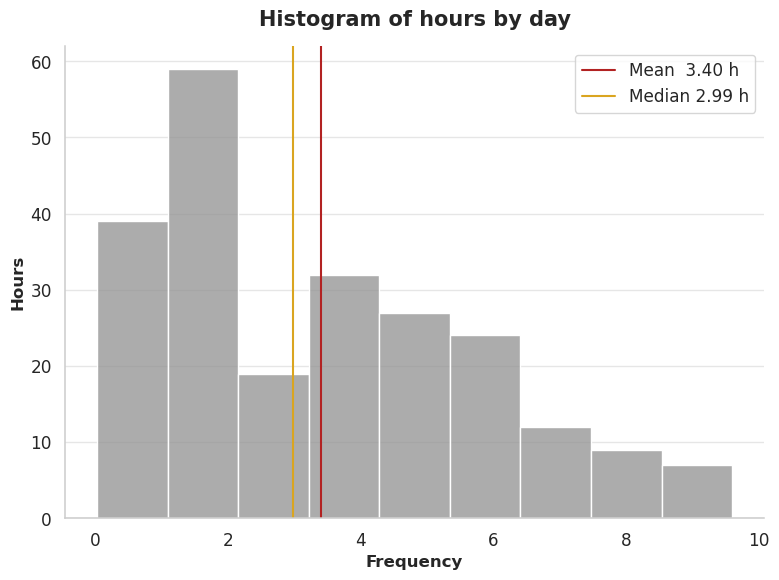

In [9]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data = bir_days_hours,
    x = "total_hours",
    bins = "auto",
    kde = False,
    color = "#919191F1"
)

ax.axvline(mean_h, color="firebrick", ls='-', lw=1.5, label=f"Mean  {mean_h:.2f} h")
ax.axvline(median_h, color="goldenrod", ls="-", lw=1.5, label=f"Median {median_h:.2f} h")

ax.legend()
ax.set_xlabel("Frequency", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Histogram of hours by day", fontsize=15, weight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/histogram_hours_per_day.png", dpi=300, bbox_inches="tight")
plt.show()

Interpretación

### Efective study days

In [10]:
num_days: int = (datetime(year= 2025, month=1, day=25) - datetime(year= 2024, month=6, day=16)).days + 1
num_days_recorded: int = len(bir_by_date.loc[4:]) 

print(f"The % of efective days is: {(num_days_recorded/num_days)*100:.0f}%")
print(f"Meaning the streak was held for all the {num_days} days")

The % of efective days is: 100%
Meaning the streak was held for all the 224 days


### Standard deviation of daily study time

In [11]:
std_hours_studied: float = bir_days_hours["total_hours"].std(ddof=0)

print(f"The standard deviation of daily study time is: {std_hours_studied:.2f} hours")

The standard deviation of daily study time is: 2.41 hours


### Highest and lowest single-day study time

In [12]:
idx_min_day: int | str = bir_days_hours["total_hours"].idxmin()
idx_max_day: int | str = bir_days_hours["total_hours"].idxmax()

min_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_min_day]
max_row: pd.DataFrame | pd.Series = bir_days_hours.loc[idx_max_day]

print(f"Day with the least time studied: {min_row["date_day"]} with {min_row["total_hours"]:.2f} hours of study time")
print(f"Day with the least time studied: {max_row["date_day"]} with {max_row["total_hours"]:.2f} hours of study time")

Day with the least time studied: 2024-07-06 00:00:00 with 0.03 hours of study time
Day with the least time studied: 2025-01-16 00:00:00 with 9.59 hours of study time


### Most and least productive week